## Author:
Zeguo Li;
Thi Thanh Thu Le (Jane Le);
Kazi Zabir Tasnimul Hassan;
Romel Cureg;
## Date created: 05 October 2023
## Date last changed: 20 October 2023
This notebook creates and save machine learning models that forecast electricity demand. Using the Kaggle dataset Daily Electricity Price and Demand Data (https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia).<br>
<br>Input: complete_dataset.csv from the kaggle site
<br>Output: trained and tested models: XGBoost.sav, RandomForest.sav, lstm_model_from_tuning <br>
<br>For the process of develpment, please refer to:
<br>EDA_and_First_Attempt.ipynb,
<br>model_building.ipynb and,
<br>test.py.

### To use the library, please pip install the libraries documented in requirements.txt


### Import

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import time 
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.dates as mdates

### Load the dataset

In [2]:
fileName = 'complete_dataset.csv'
demand_dataset = pd.read_csv(fileName)

### Ignore warnings - consider checking this option in the future in debugging

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Exploratory Data Analysis
### First six row of the dataset

In [4]:
demand_dataset.head(6)

date      demand        RRP  demand_pos_RRP  RRP_positive  \
0  2015-01-01   99635.030  25.633696       97319.240     26.415953   
1  2015-01-02  129606.010  33.138988      121082.015     38.837661   
2  2015-01-03  142300.540  34.564855      142300.540     34.564855   
3  2015-01-04  104330.715  25.005560      104330.715     25.005560   
4  2015-01-05  118132.200  26.724176      118132.200     26.724176   
5  2015-01-06  130672.485  31.282311      130672.485     31.282311   

   demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
0        2315.790     -7.240000         0.020833             13.3   
1        8523.995    -47.809777         0.062500             15.4   
2           0.000      0.000000         0.000000             20.0   
3           0.000      0.000000         0.000000             16.3   
4           0.000      0.000000         0.000000             15.0   
5           0.000      0.000000         0.000000             17.7   

   max_temperature  solar_exposure  rainfall school_day holiday  
0             26.9            23.6       0.0          N       Y  
1             38.8            26.8       0.0          N       N  
2             38.2            26.5       0.0          N       N  
3             21.4            25.2       4.2          N       N  
4             22.0            30.7       0.0          N       N  
5             26.0            31.6       0.0          N       N

### Dataset shape

In [5]:
print(demand_dataset.shape)

(2106, 14)


### Check for missing values

In [6]:
demand_dataset.info()
print(demand_dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB
date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive      

From the result above, we can see that there are 3 entries with rainfall value missing, and 1 entry that misses solar_exposure value 
### Find out the row that contains missing value(s)

In [7]:
print(demand_dataset[demand_dataset.isnull().any(axis=1)])

            date      demand        RRP  demand_pos_RRP  RRP_positive  \
161   2015-06-11  143465.445  37.481829      143465.445     37.481829   
1060  2017-11-26  108717.875  83.114514      108717.875     83.114514   
1377  2018-10-09  116449.310  99.000749      116449.310     99.000749   
1378  2018-10-10  109551.080  73.539698      109551.080     73.539698   

      demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
161              0.0           0.0              0.0              5.7   
1060             0.0           0.0              0.0             19.4   
1377             0.0           0.0              0.0             16.1   
1378             0.0           0.0              0.0             10.1   

      max_temperature  solar_exposure  rainfall school_day holiday  
161              14.0             8.3       NaN          Y       N  
1060             28.3             NaN       3.4          Y       N  
1377             17.9             7.2       NaN          Y       N

### Check for duplicated entry(s)

In [8]:
print(demand_dataset.duplicated())
print("Number of duplicated entry is :", demand_dataset.duplicated().sum())

0       False
1       False
2       False
3       False
4       False
        ...  
2101    False
2102    False
2103    False
2104    False
2105    False
Length: 2106, dtype: bool
Number of duplicated entry is : 0


### Minimum and Maximum value of the demand feature

In [9]:
print("Minimum:",demand_dataset['demand'].min())
print("Maximum", demand_dataset['demand'].max())
print("Difference", demand_dataset['demand'].max() - demand_dataset['demand'].min())

Minimum: 85094.37499999999
Maximum 170653.84000000003
Difference 85559.46500000004


### Distribution of school_day and holiday

school_day
N     653
Y    1453
dtype: int64 


 holiday
N    2029
Y      77
dtype: int64


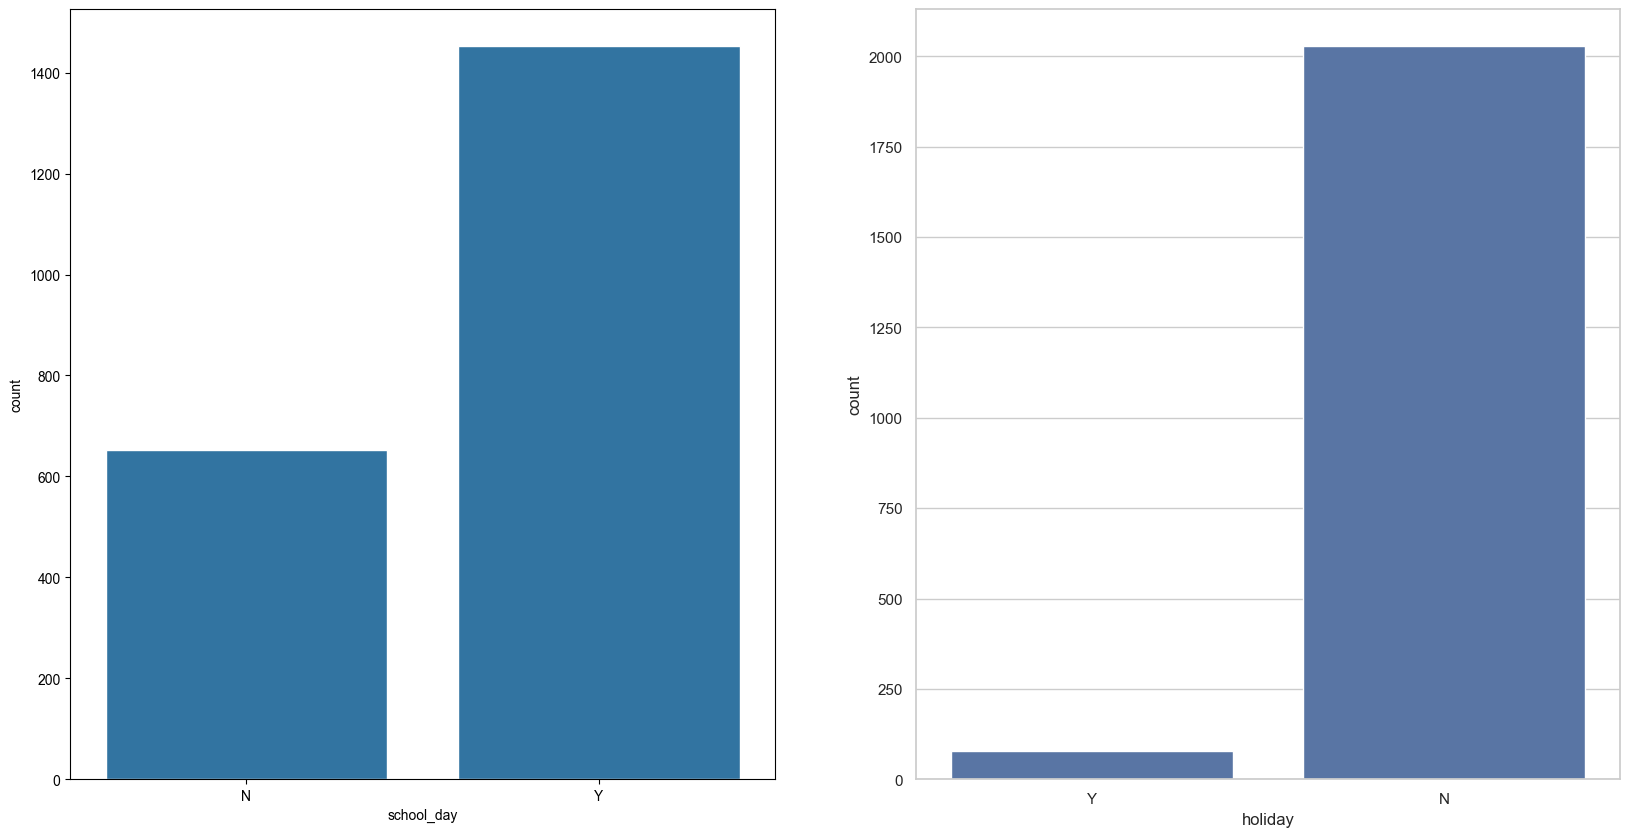

In [10]:
distSD = demand_dataset.groupby('school_day').size()
distHO = demand_dataset.groupby('holiday').size()
print(distSD, '\n'*3, distHO)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.set_theme(style = 'whitegrid')
sdDist = sns.countplot(x = demand_dataset['school_day'])
plt.subplot(1,2,2)
sns.set_theme(style = 'whitegrid')
hoDist = sns.countplot(x = demand_dataset['holiday'])
plt.show()

### Daily electricity demand and daily average RRP for electricity from 2015 to 2020

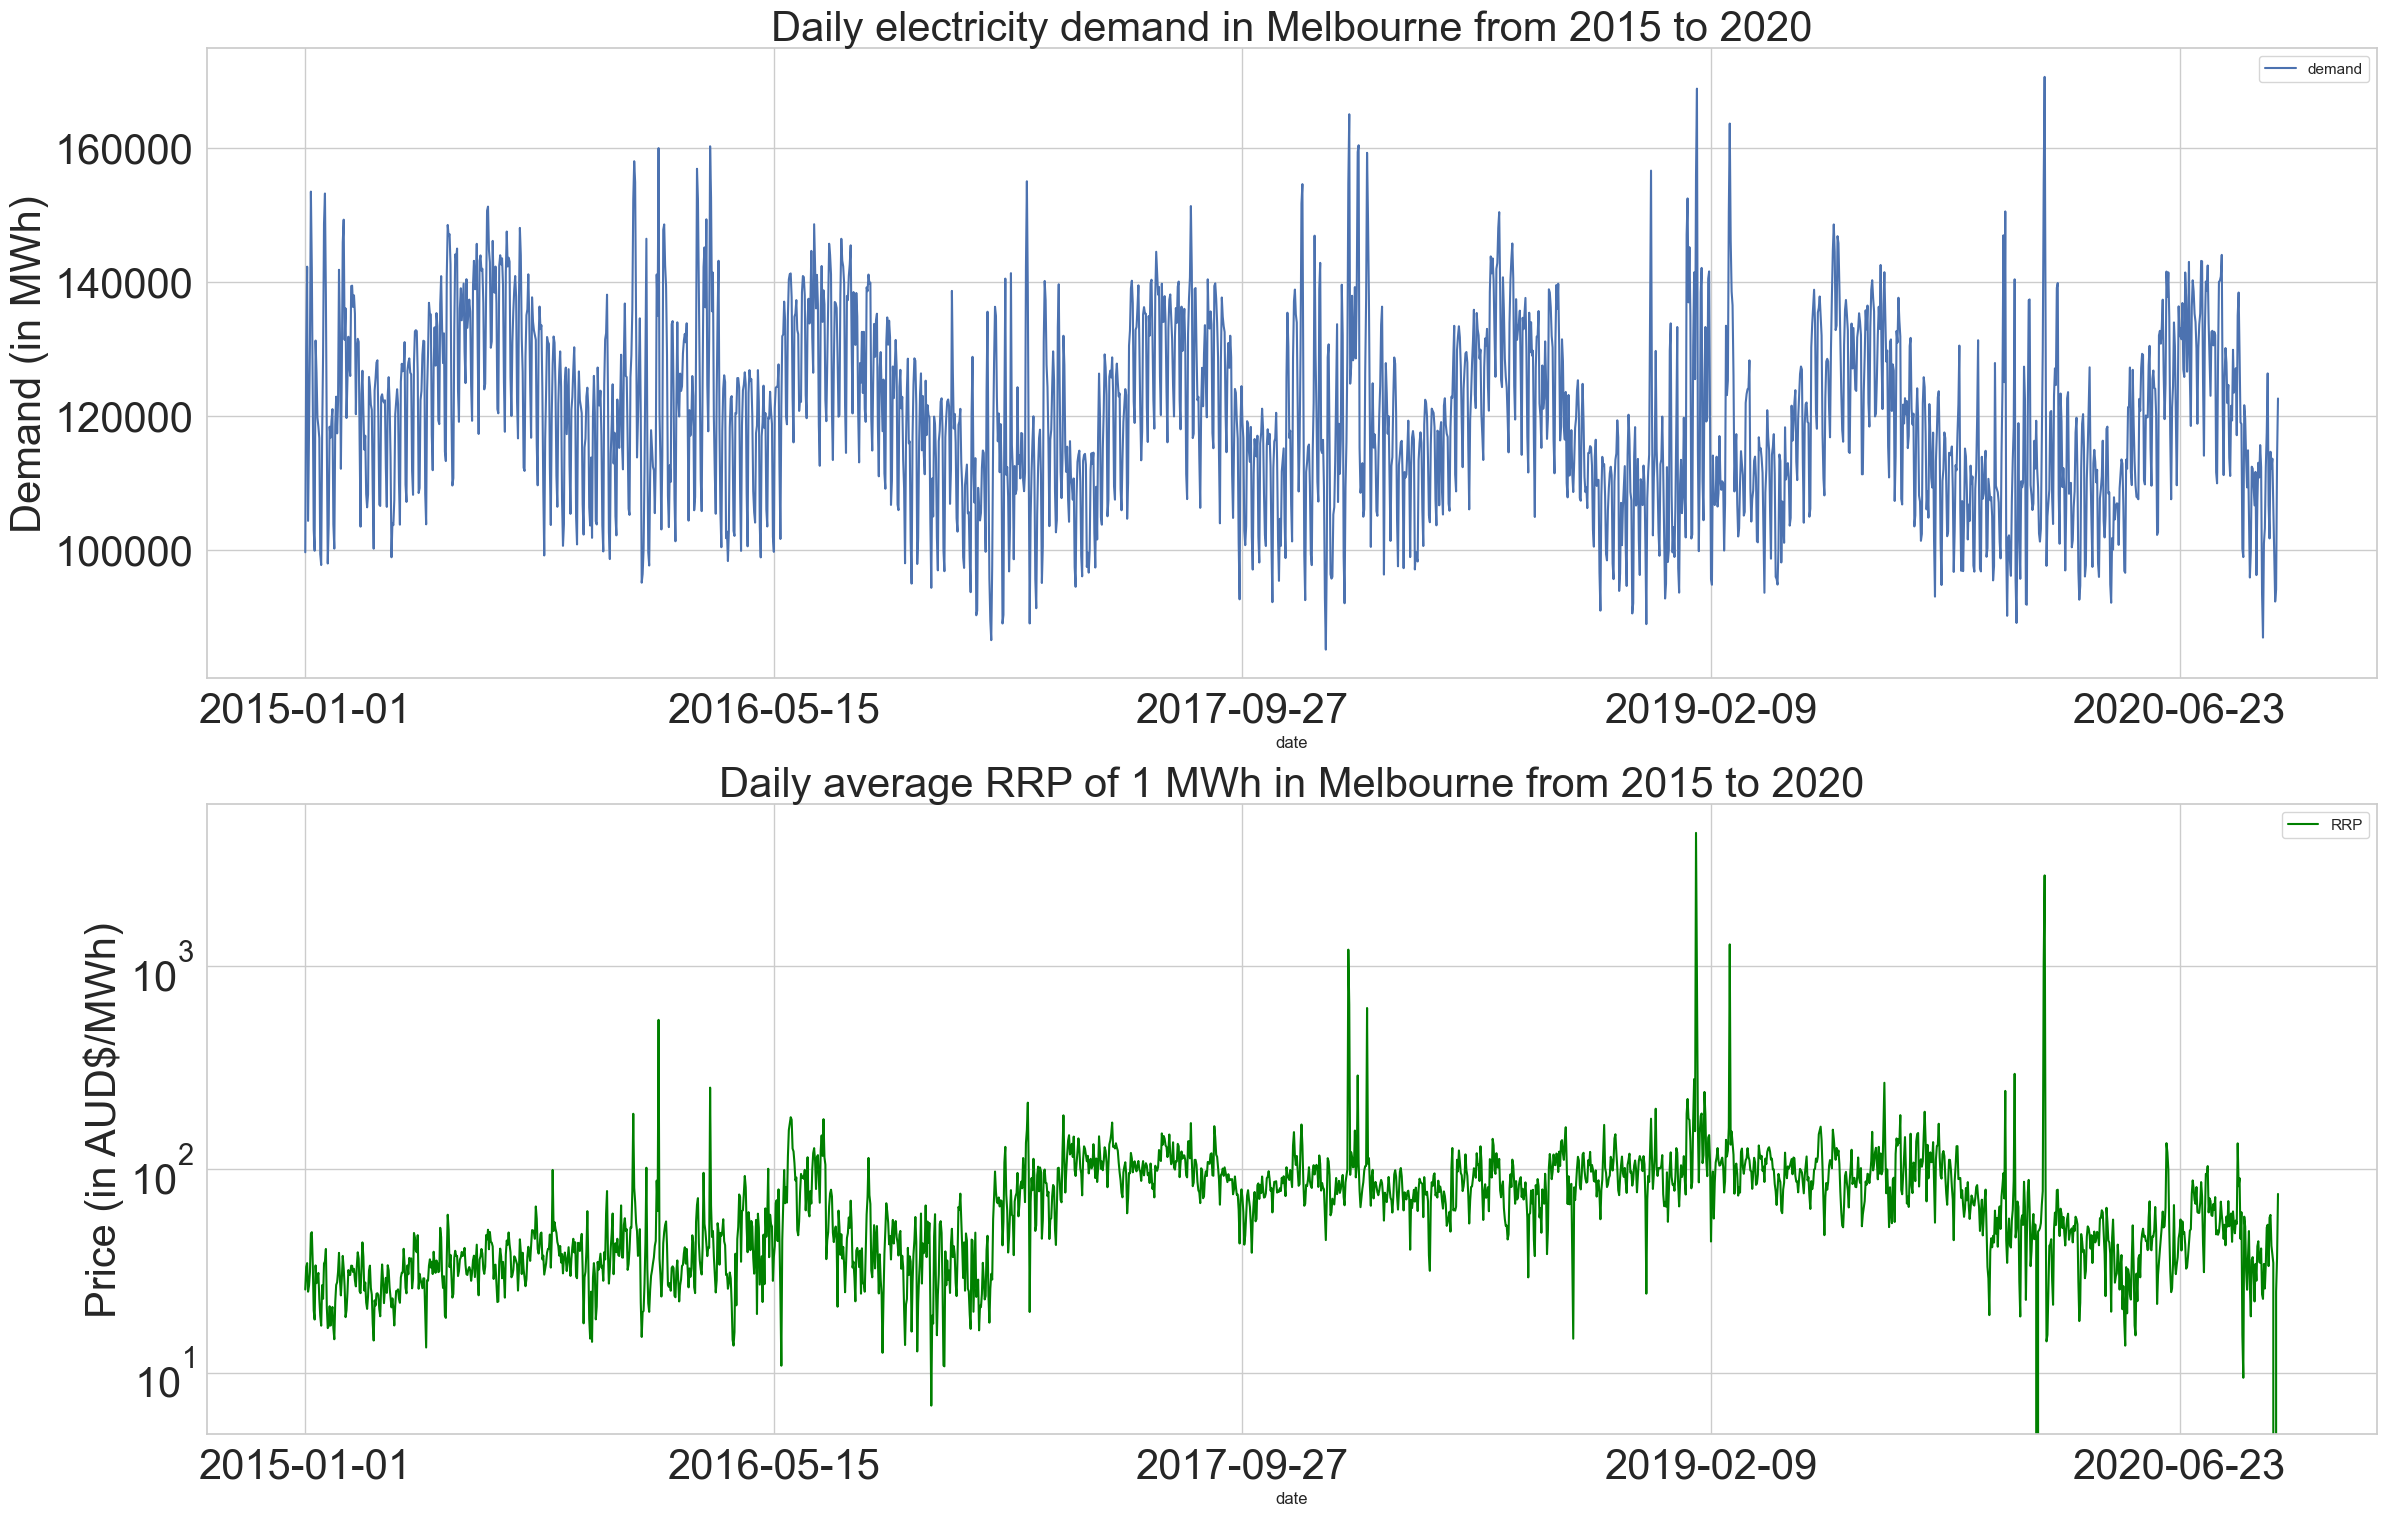

In [11]:
fig, ax = plt.subplots(2, 1, figsize = (28, 18))
ax[0].tick_params(labelsize=30)
demand_dataset.plot('date','demand', ax = ax[0])
ax[0].set_title("Daily electricity demand in Melbourne from 2015 to 2020", size = 30)
ax[0].set_ylabel("Demand (in MWh)", fontsize = 30)
# plt.grid(True)
demand_dataset.plot('date','RRP', color='green', ax = ax[1])
ax[1].tick_params(labelsize=30)
ax[1].set_title("Daily average RRP of 1 MWh in Melbourne from 2015 to 2020", size = 30)
ax[1].set_ylabel("Price (in AUD$/MWh)", fontsize = 30)
plt.yscale('log')
plt.show()

### Climate data

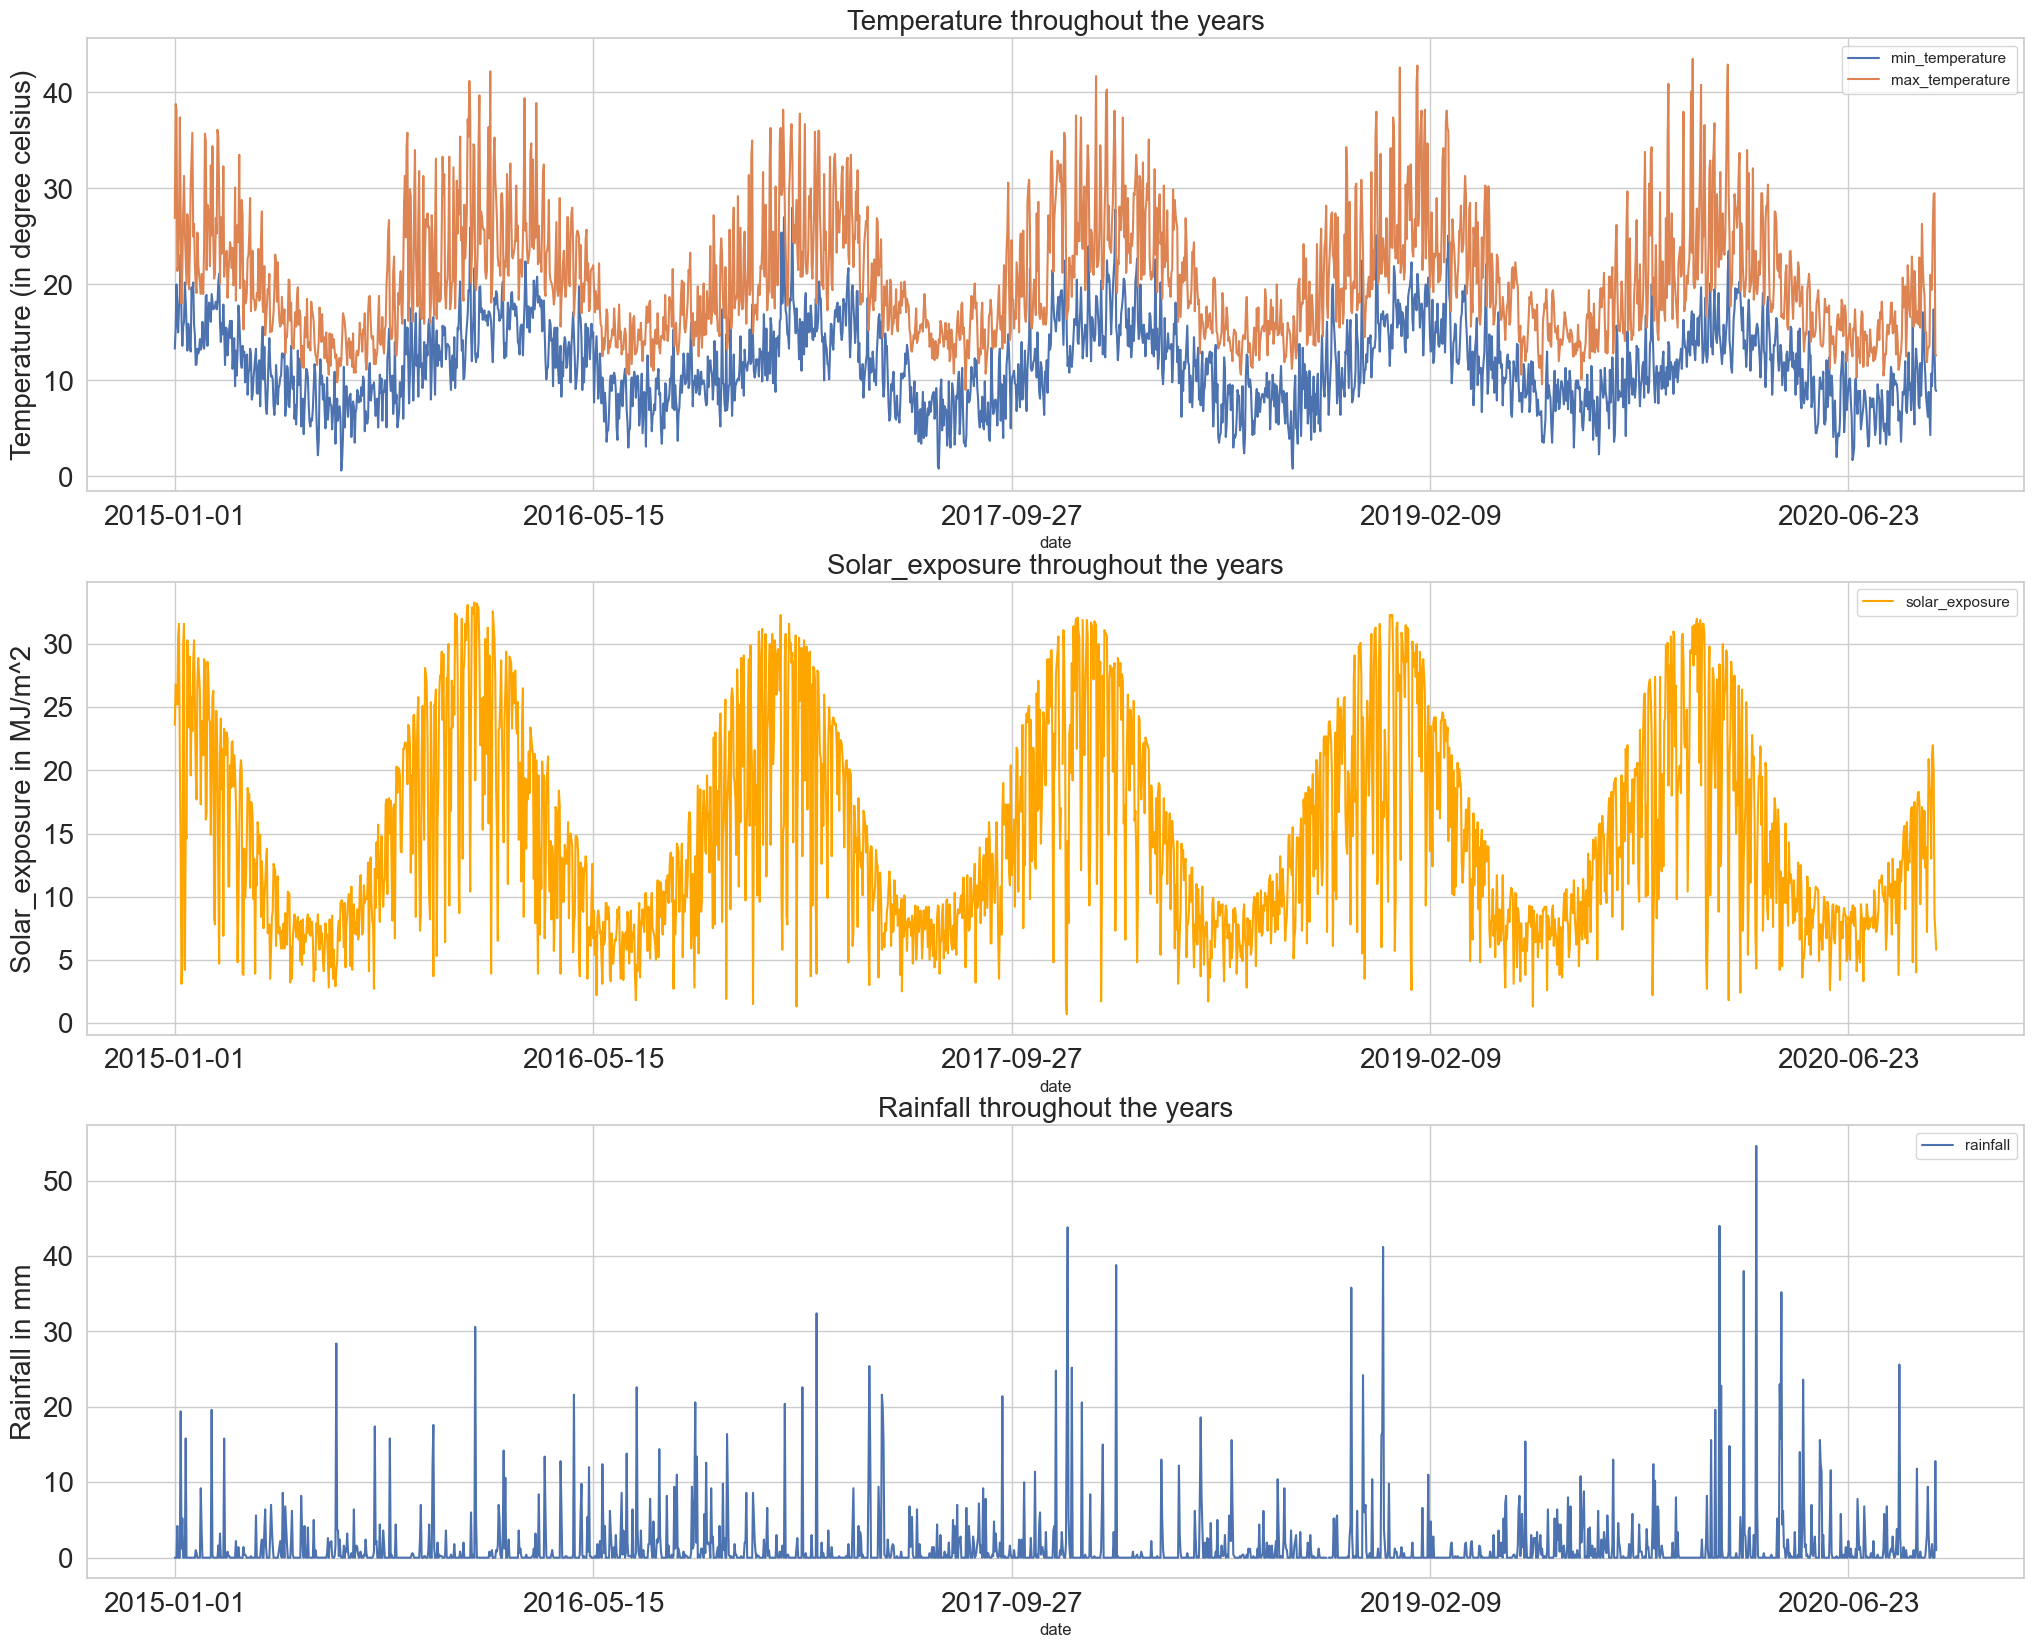

In [12]:
fig, ax = plt.subplots(3, 1, figsize = (25, 20))
demand_dataset.plot('date', ['min_temperature', 'max_temperature'], ax = ax[0])
ax[0].tick_params(labelsize=20)
ax[0].set_title("Temperature throughout the years", size = 20)
ax[0].set_ylabel("Temperature (in degree celsius)", fontsize = 20)
demand_dataset.plot('date', 'solar_exposure', ax = ax[1], color = 'orange')
ax[1].tick_params(labelsize=20)
ax[1].set_title("Solar_exposure throughout the years", size = 20)
ax[1].set_ylabel("Solar_exposure in MJ/m^2", fontsize = 20)
demand_dataset.plot('date', 'rainfall', ax = ax[2])
ax[2].tick_params(labelsize=20)
ax[2].set_title("Rainfall throughout the years", size = 20)
ax[2].set_ylabel("Rainfall in mm", fontsize = 20)
plt.show()

### Correlation Matrix

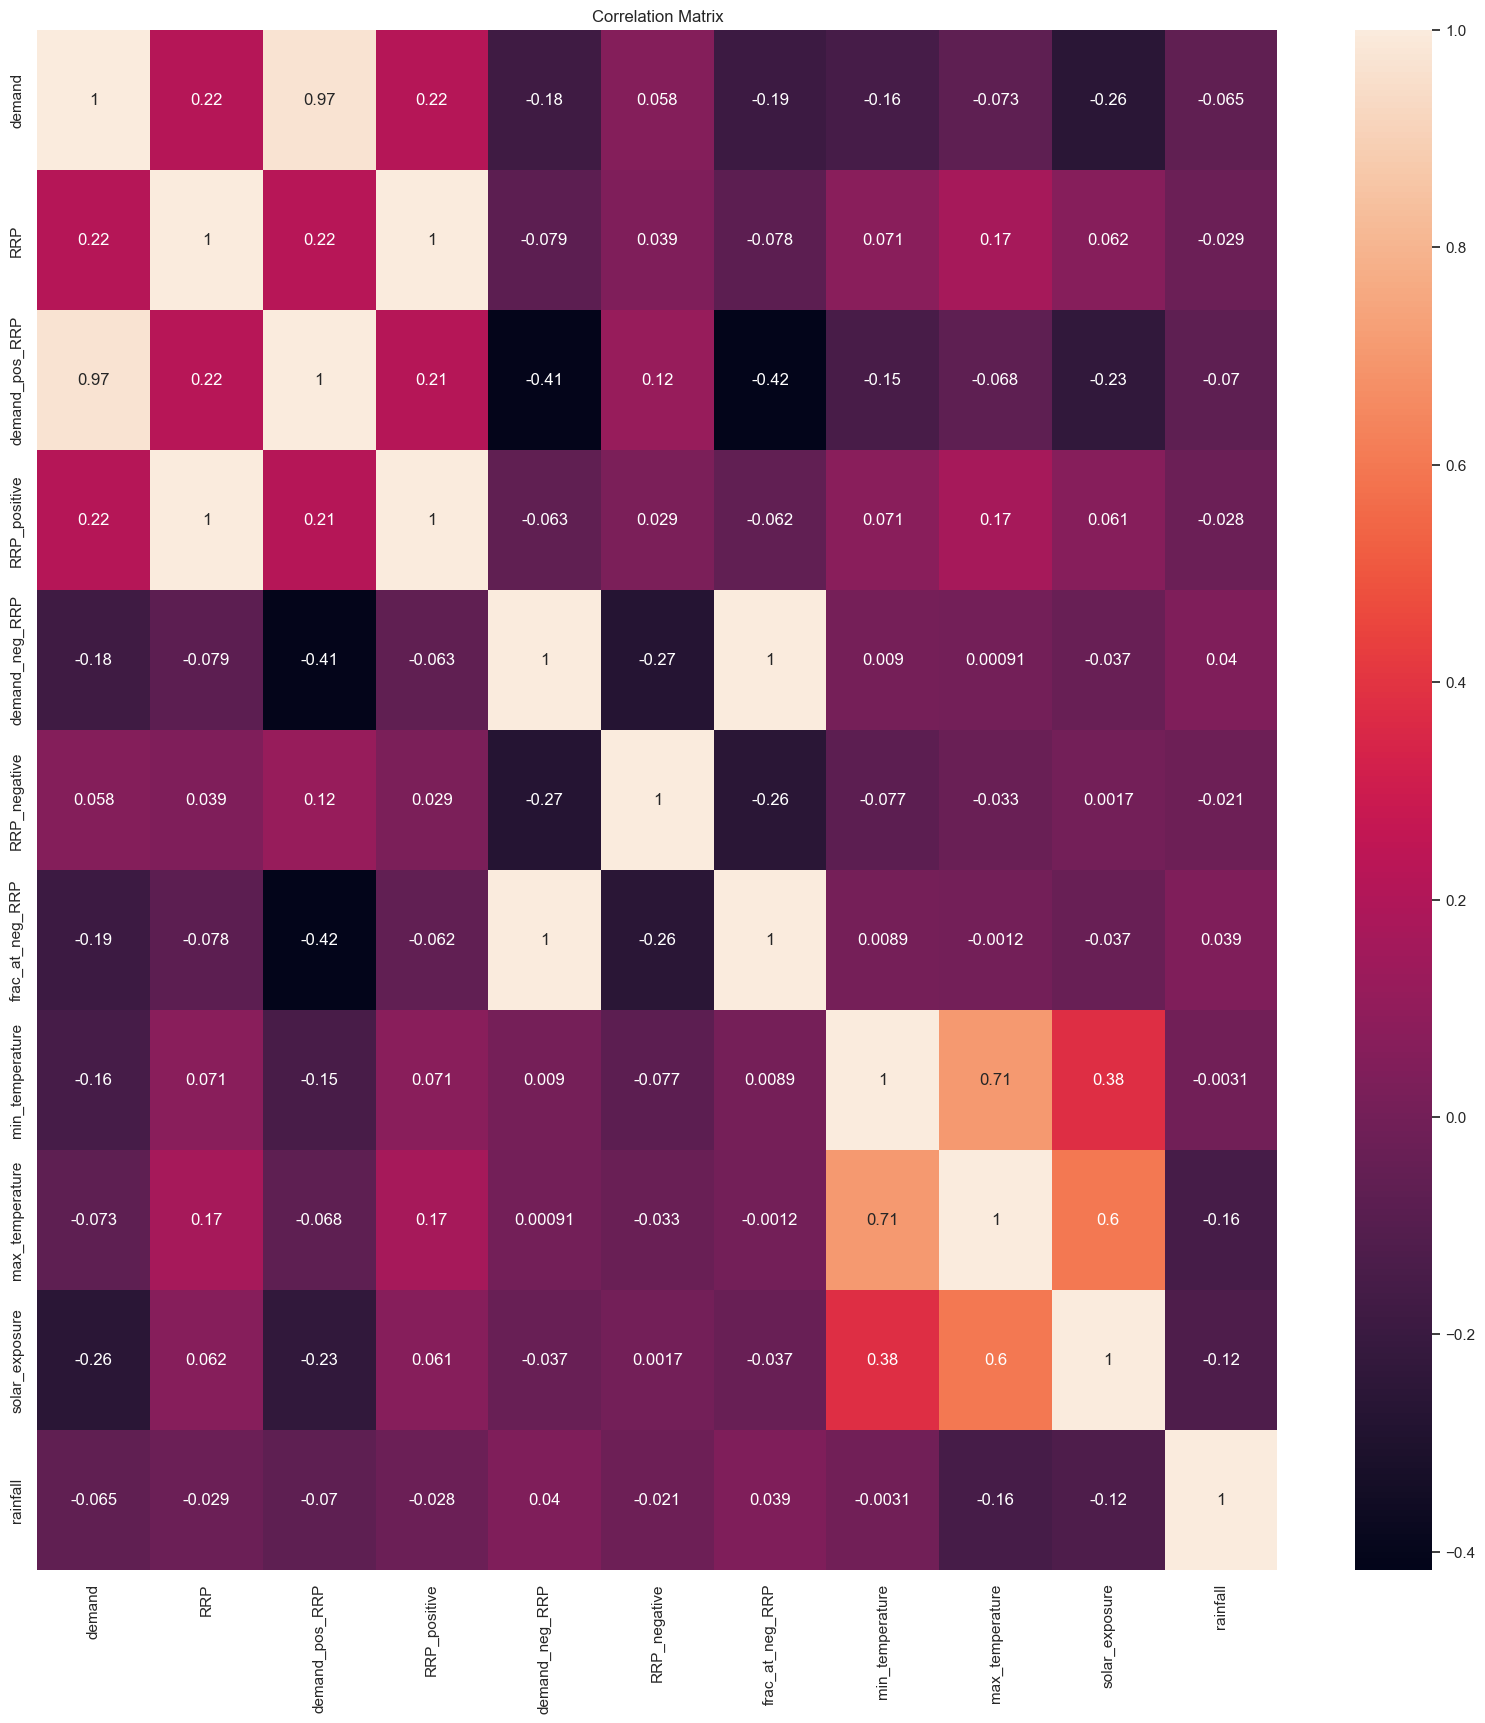

In [13]:
# Convert the data type of 'school_day' and 'holiday' into dummy variable for the heatmap
demand_dataset = pd.read_csv(fileName, index_col=0)
pd.to_datetime(demand_dataset.index)
demand_dataset['school_day'] = demand_dataset['school_day'].replace({'Y':1, 'N':0})
demand_dataset['holiday'] = demand_dataset['holiday'].replace({'Y':1, 'N':0})
demand_dataset[25:30]

# Heat map
heat_map, ax = plt.subplots(figsize=(20, 20)) #Set size of the heat map
sns.heatmap(demand_dataset.iloc[:, [0,1,2,3,4,5,6,7,8,9,10]].corr(), annot=True, ax = ax)
plt.title("Correlation Matrix")
plt.show()

### Seasonality and trend analysis of demand and RRP using seasonal_component with additive model (linear regression)

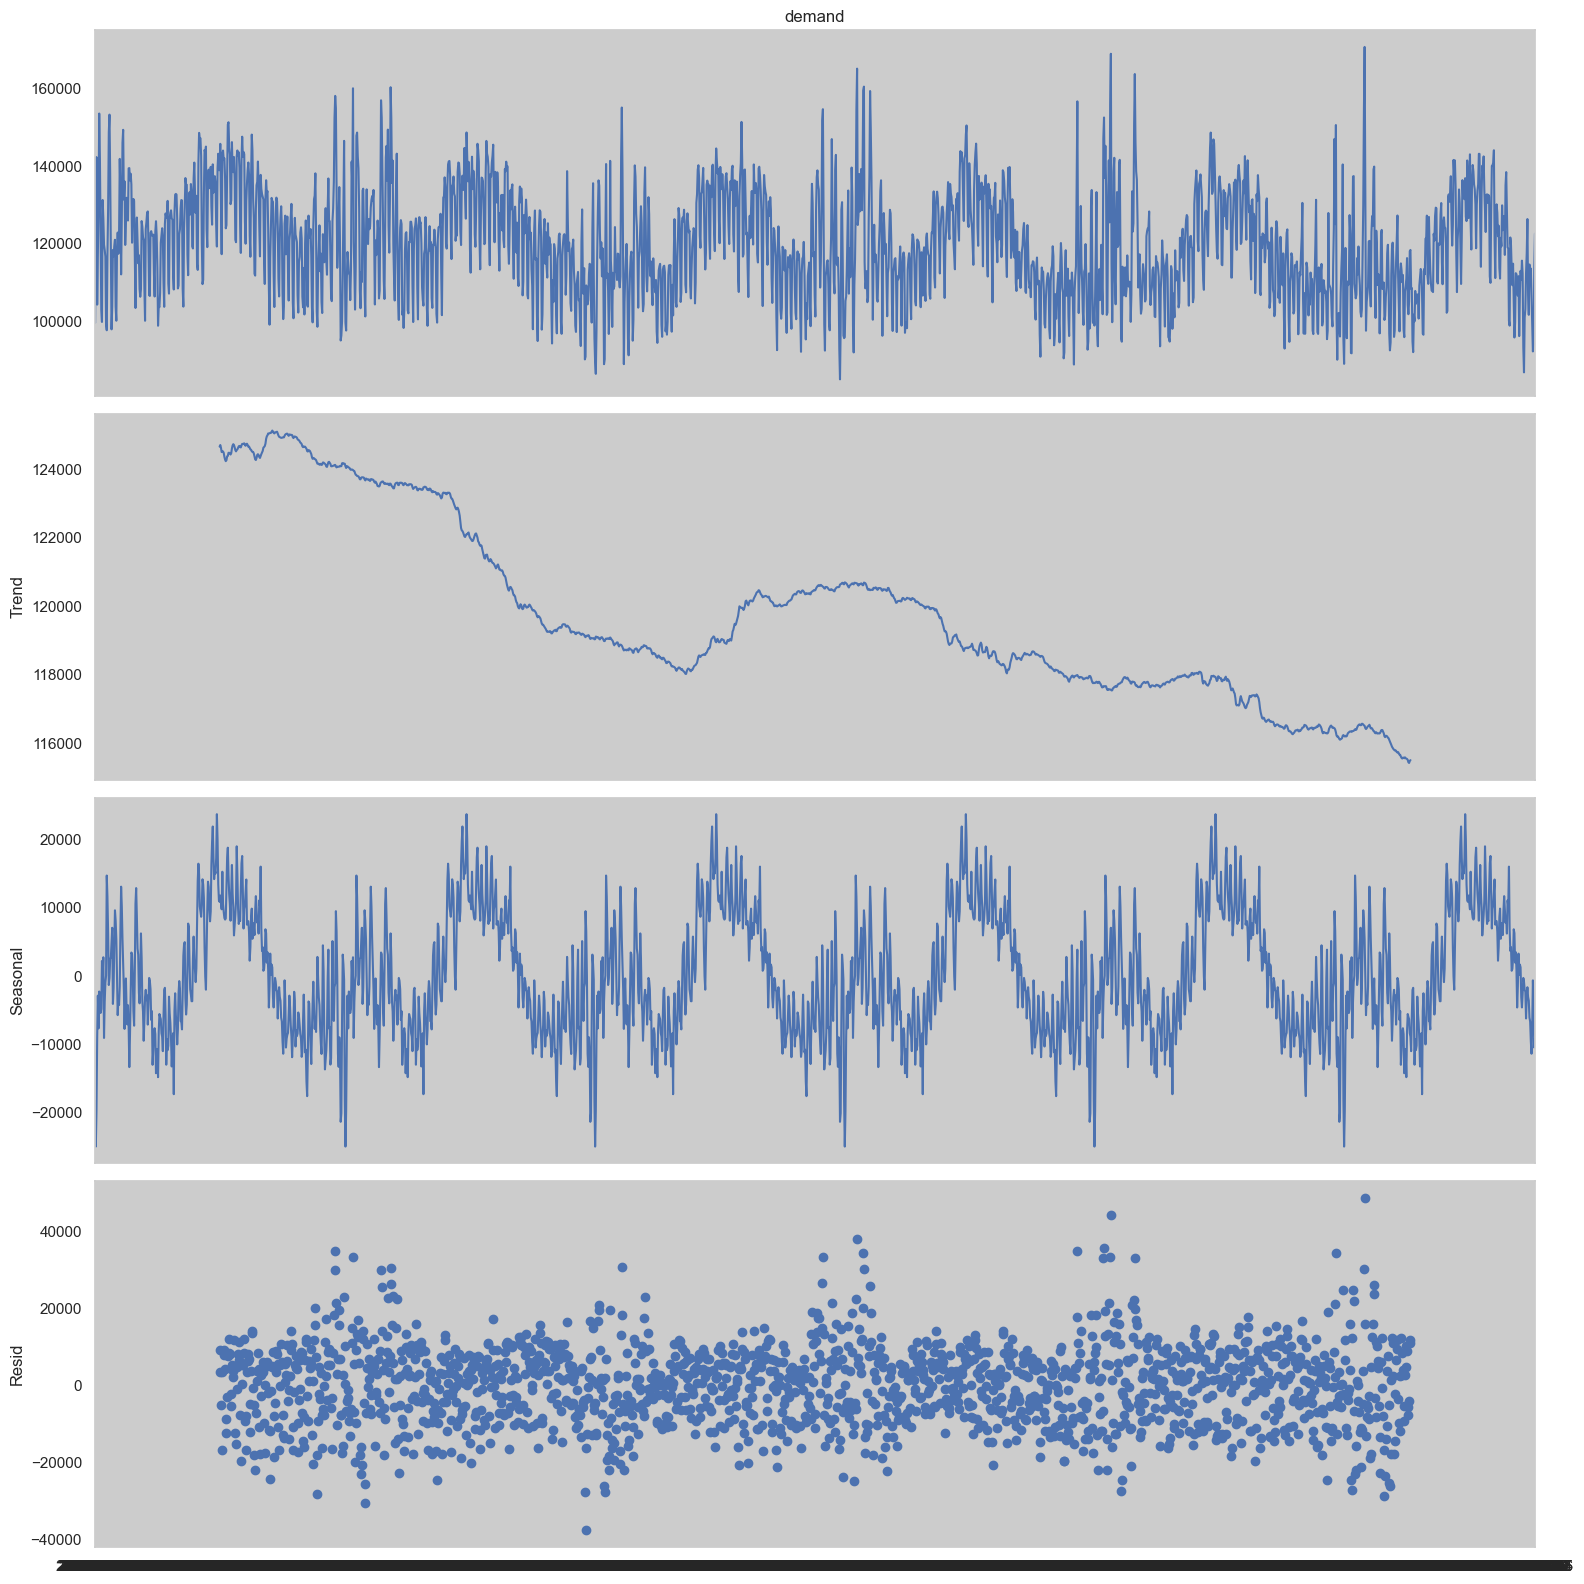

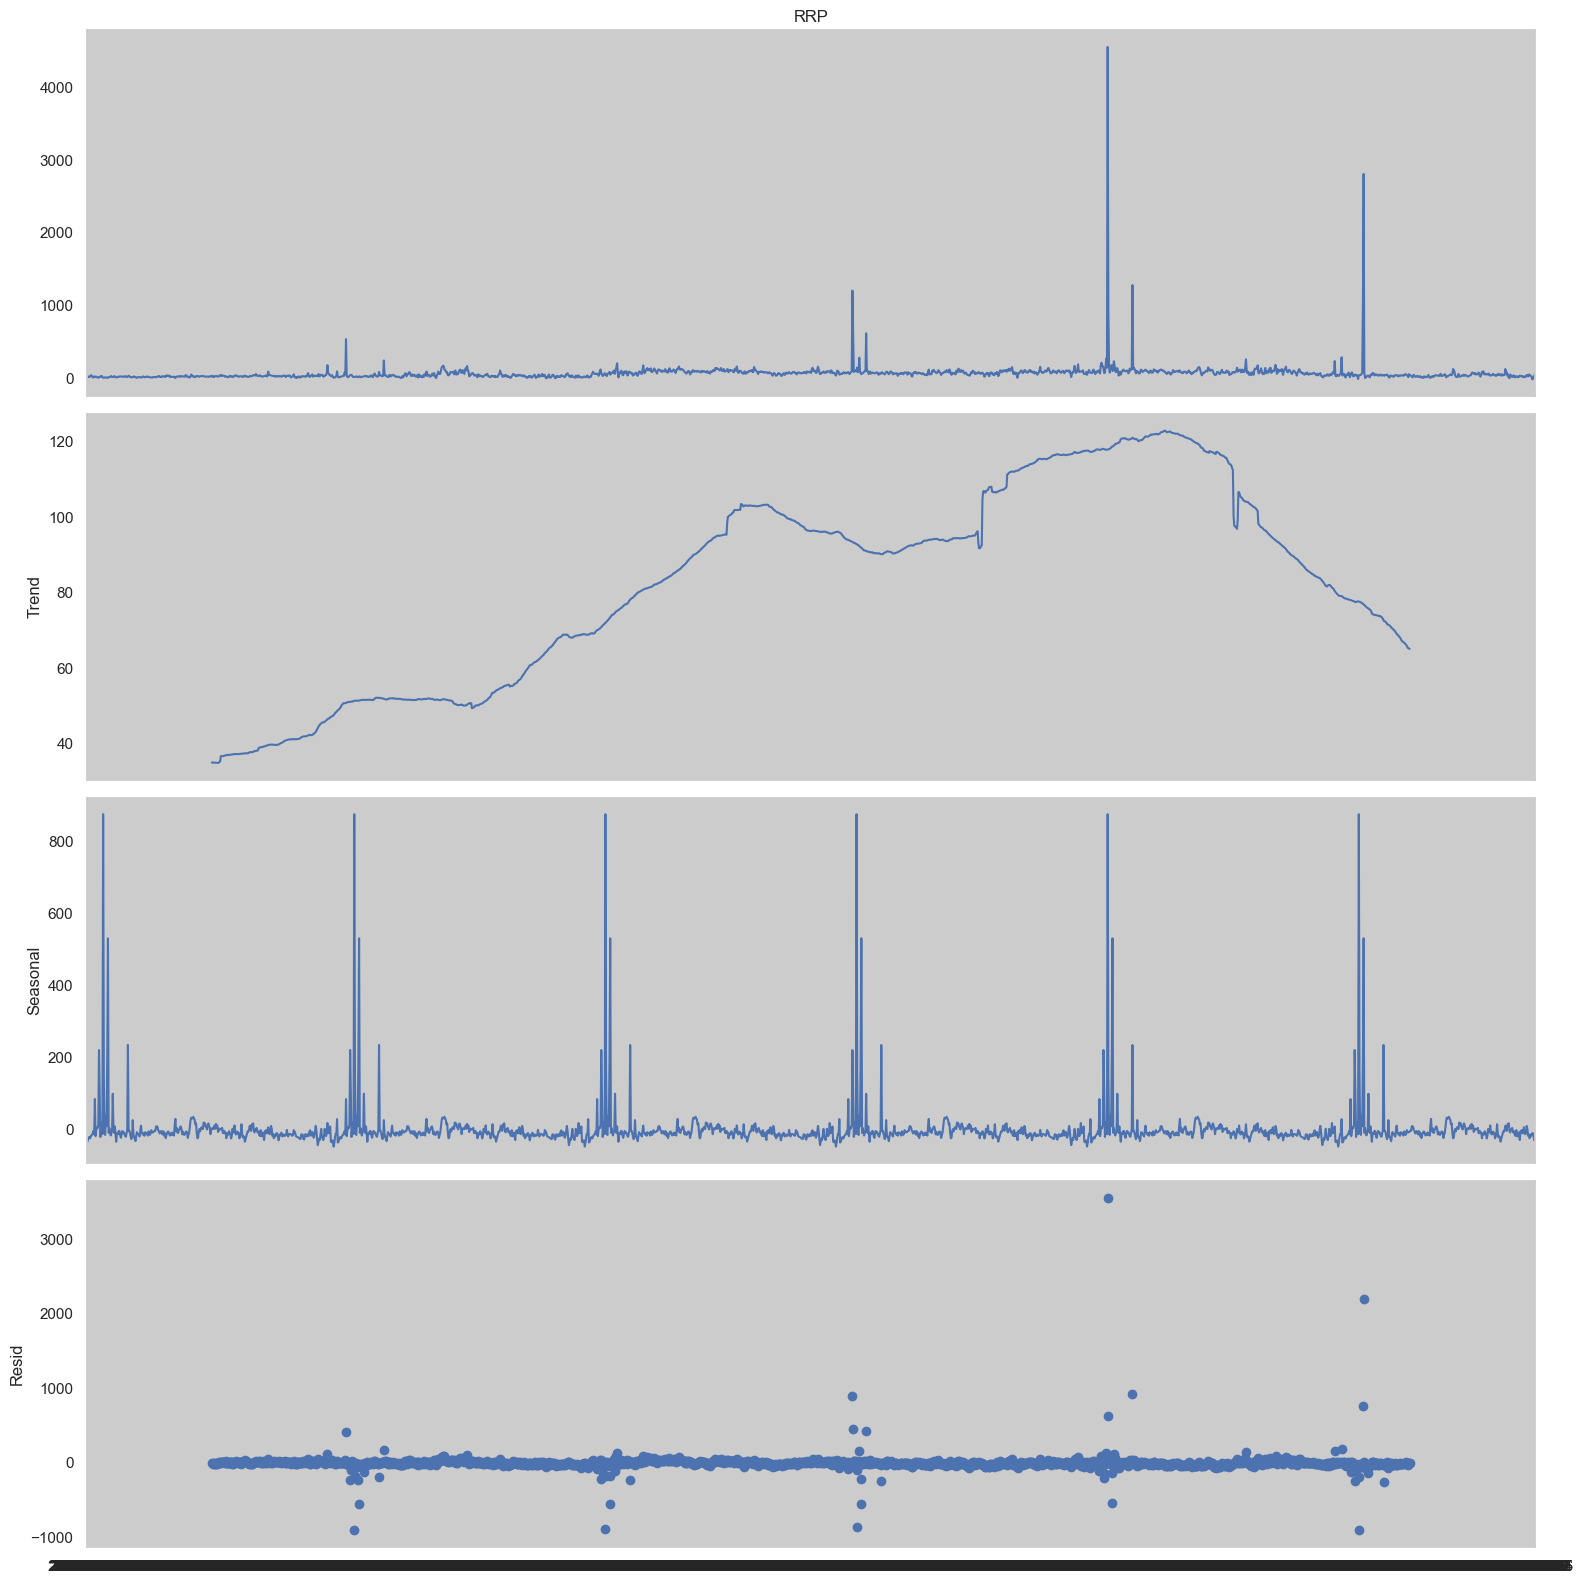

In [14]:
plt.rcParams["figure.figsize"] = (16, 16)
seasonal_decompose(demand_dataset['demand'], period=365, model='add').plot()
plt.show()
plt.rcParams["figure.figsize"] = (16, 16)
seasonal_decompose(demand_dataset['RRP'], period=365, model='add').plot()
plt.show()

### Outlier Analysis - Demand

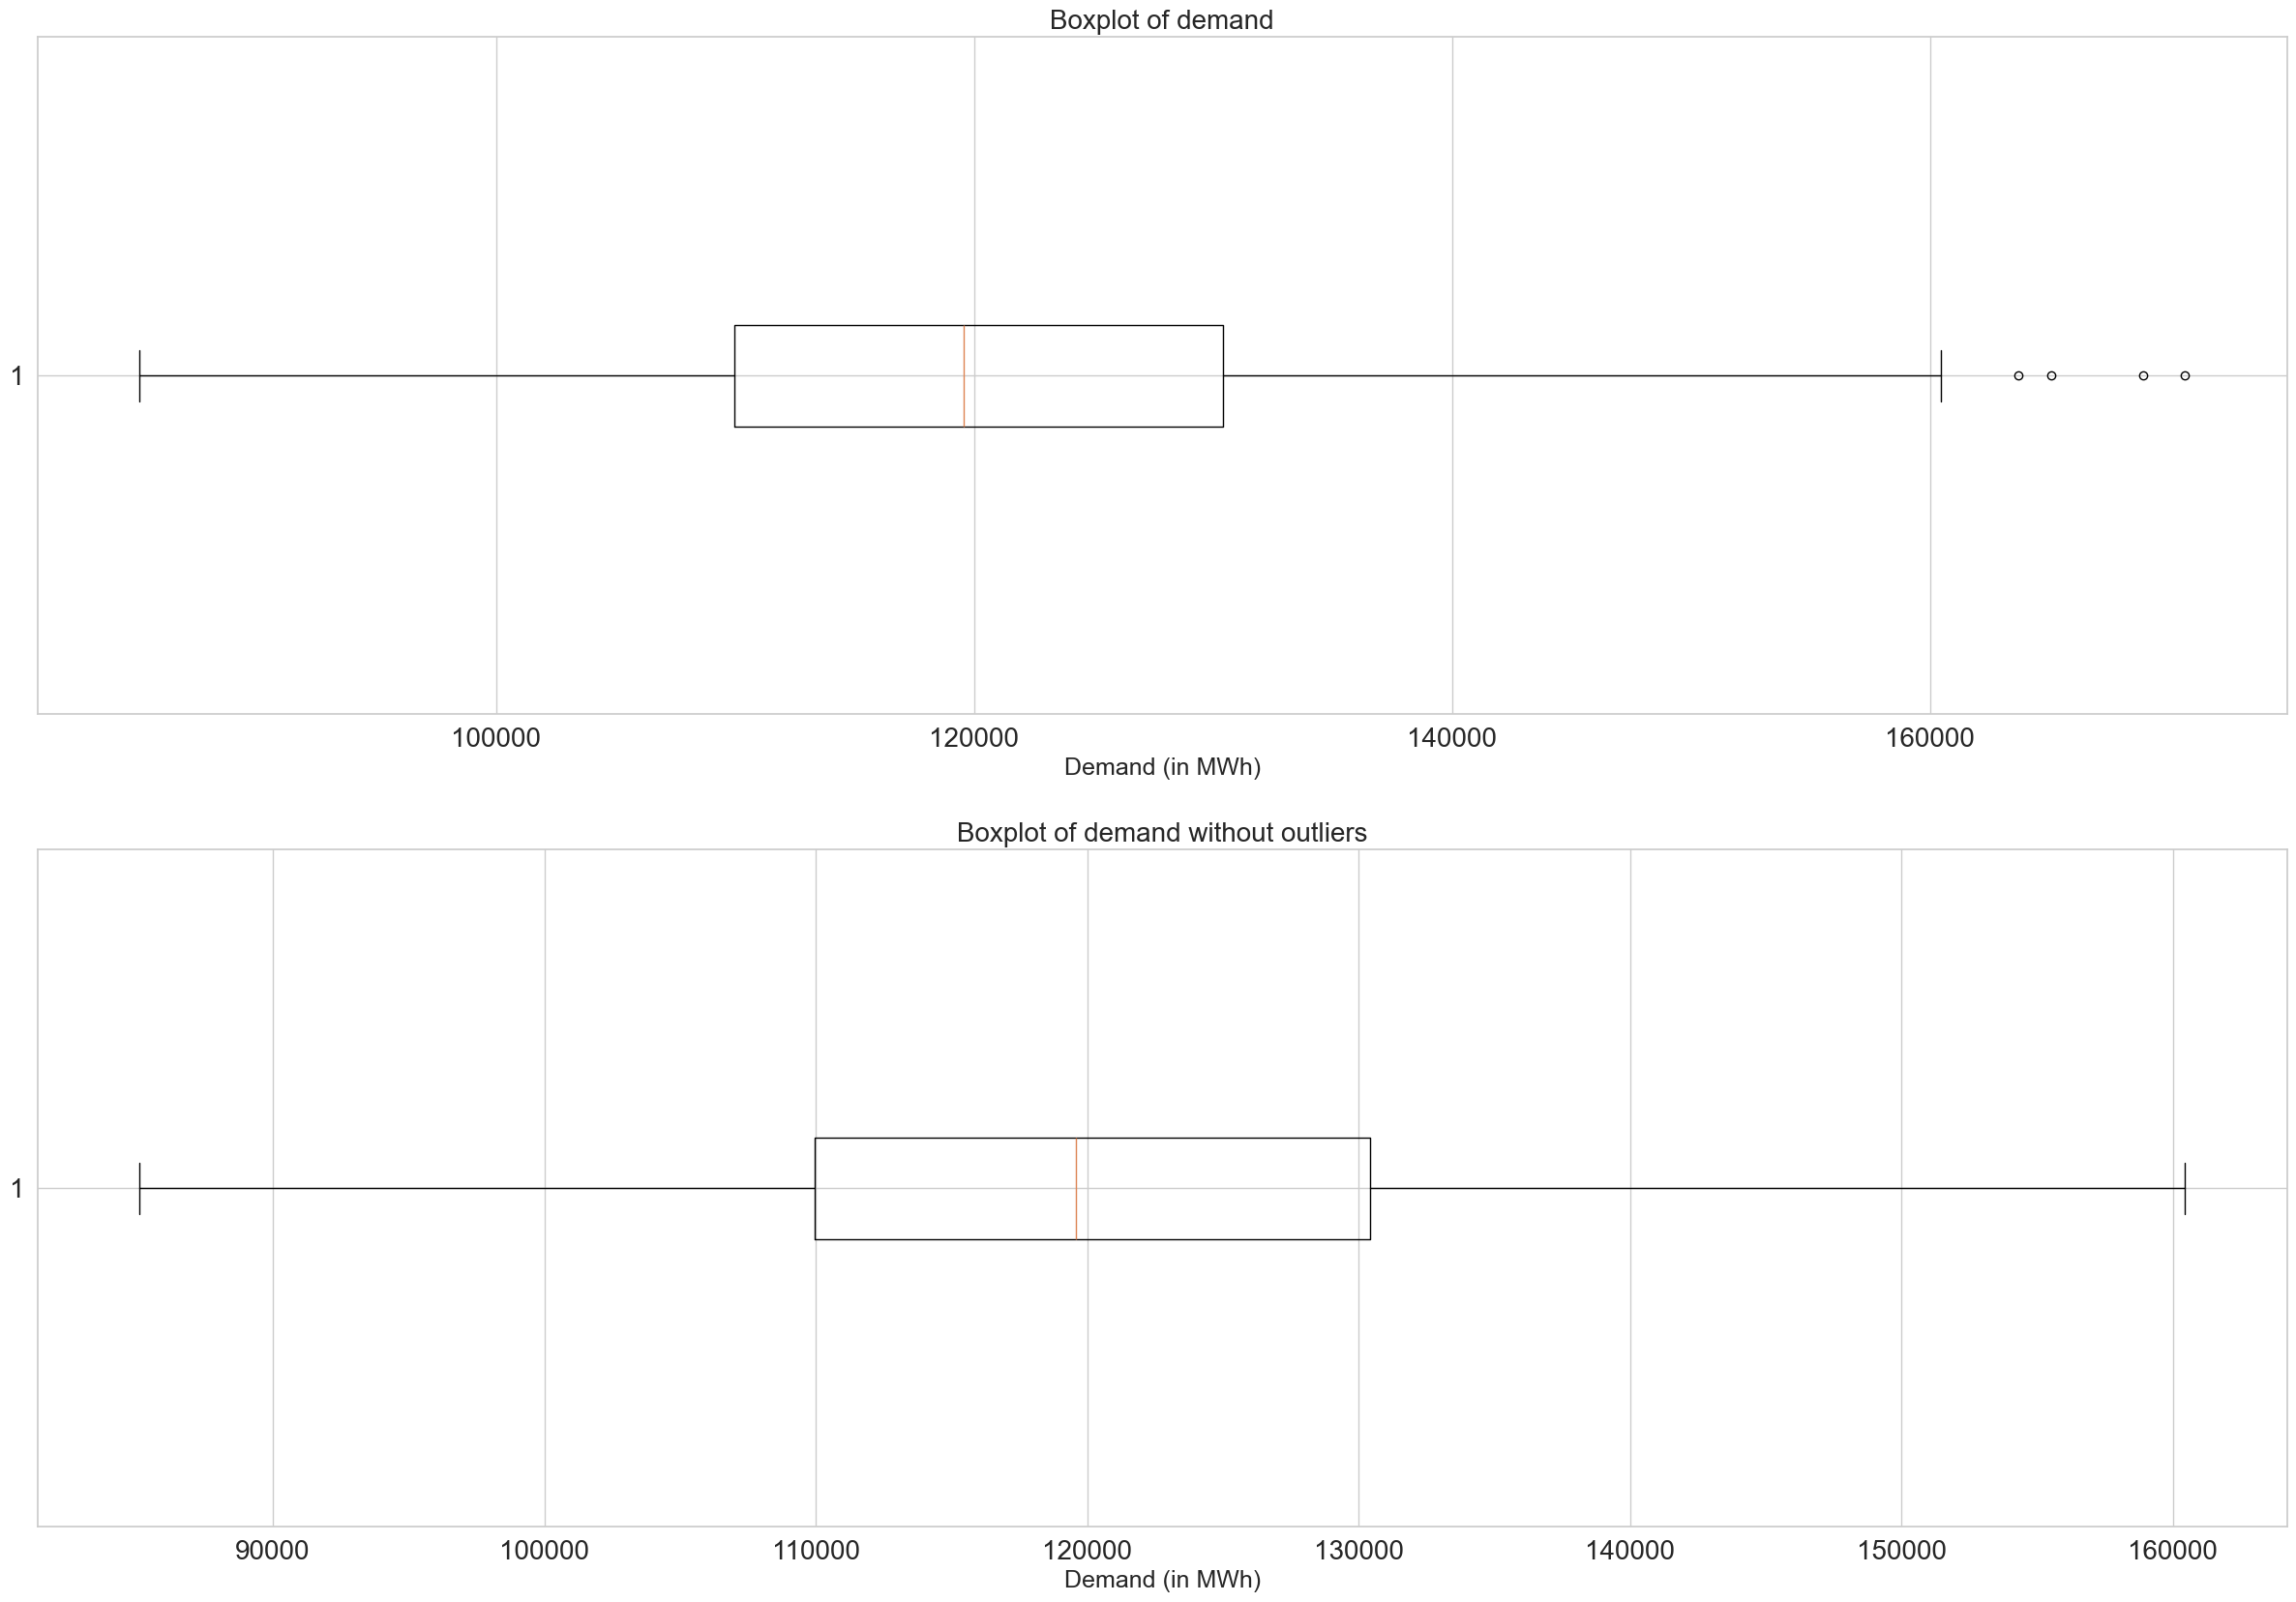

In [15]:
fig, ax = plt.subplots(2, 1, figsize = (30, 20))
ax[0].boxplot(demand_dataset['demand'], vert = False)
ax[0].tick_params(labelsize=20)
ax[0].set_title('Boxplot of demand', size = 20)
ax[0].set_xlabel("Demand (in MWh)", fontsize = 18)

ax[1].boxplot(demand_dataset['demand'], vert = False, showfliers= False)
ax[1].tick_params(labelsize=20)
ax[1].set_title("Boxplot of demand without outliers", size = 20)
ax[1].set_xlabel("Demand (in MWh)", fontsize = 18)

plt.show()

### Find outlier location

In [16]:
df = demand_dataset.copy()
def findOutlier(column):
    data = np.array(demand_dataset[column])
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    rowWithOutlier = demand_dataset[column].isin(outliers)
    outlierDF = df[rowWithOutlier]
    return outlierDF

featureSelected = ['demand',
                    'RRP',
                    'min_temperature',
                    'max_temperature',
                    'solar_exposure',
                    'rainfall']
for feature in featureSelected:
    outlierdf = findOutlier(feature)
    if outlierdf.empty:
        print("\n\nNo outlier found in feature", feature)
    else:
        print('*'*10 ,f'In feature {feature}, here are the outliers:\n\n', findOutlier(feature))


********** In feature demand, here are the outliers:

                 demand          RRP  demand_pos_RRP  RRP_positive  \
date                                                                
2018-01-19  165070.595   647.574163      165070.595    647.574163   
2019-01-25  168894.845   906.437232      168894.845    906.437232   
2019-03-01  163682.040  1284.799876      163682.040   1284.799876   
2020-01-31  170653.840  2809.437516      170653.840   2809.437516   

            demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
date                                                                         
2018-01-19             0.0           0.0              0.0             22.5   
2019-01-25             0.0           0.0              0.0             21.1   
2019-03-01             0.0           0.0              0.0             22.6   
2020-01-31             0.0           0.0              0.0             21.5   

            max_temperature  solar_exposure  rainfall  school

Outlier intersection

In [17]:
outlierDF = findOutlier('demand')
demandOutIndex = outlierDF.index.to_list()
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
for feature in featureSelected:
    indexToCompare = findOutlier(feature).index.to_list()
    print(f'intersection of outlier for demand and {feature} is: '
          , intersection(indexToCompare, demandOutIndex))

intersection of outlier for demand and demand is:  ['2018-01-19', '2019-01-25', '2019-03-01', '2020-01-31']
intersection of outlier for demand and RRP is:  ['2018-01-19', '2019-01-25', '2019-03-01', '2020-01-31']
intersection of outlier for demand and min_temperature is:  []
intersection of outlier for demand and max_temperature is:  ['2018-01-19', '2019-01-25', '2019-03-01', '2020-01-31']
intersection of outlier for demand and solar_exposure is:  []
intersection of outlier for demand and rainfall is:  []


### Average demand per weekday and month of year

    dayOfWeek  year         demand
0           0  2015  125745.964135
1           0  2016  123991.728846
2           0  2017  120687.639712
3           0  2018  120151.329340
4           0  2019  121001.923942
5           0  2020  118679.396875
6           1  2015  129902.052019
7           1  2016  128163.811058
8           1  2017  124304.535481
9           1  2018  121701.400962
10          1  2019  121122.076604
11          1  2020  121847.273750
12          2  2015  131351.057308
13          2  2016  129702.936346
14          2  2017  125921.177404
15          2  2018  122445.789712
16          2  2019  122554.503462
17          2  2020  121150.143125
18          3  2015  131387.804434
19          3  2016  128036.178846
20          3  2017  125774.572692
21          3  2018  124983.046731
22          3  2019  122523.272596
23          3  2020  122663.223250
24          4  2015  129072.644423
25          4  2016  125356.466509
26          4  2017  122041.864712
27          4  2018 

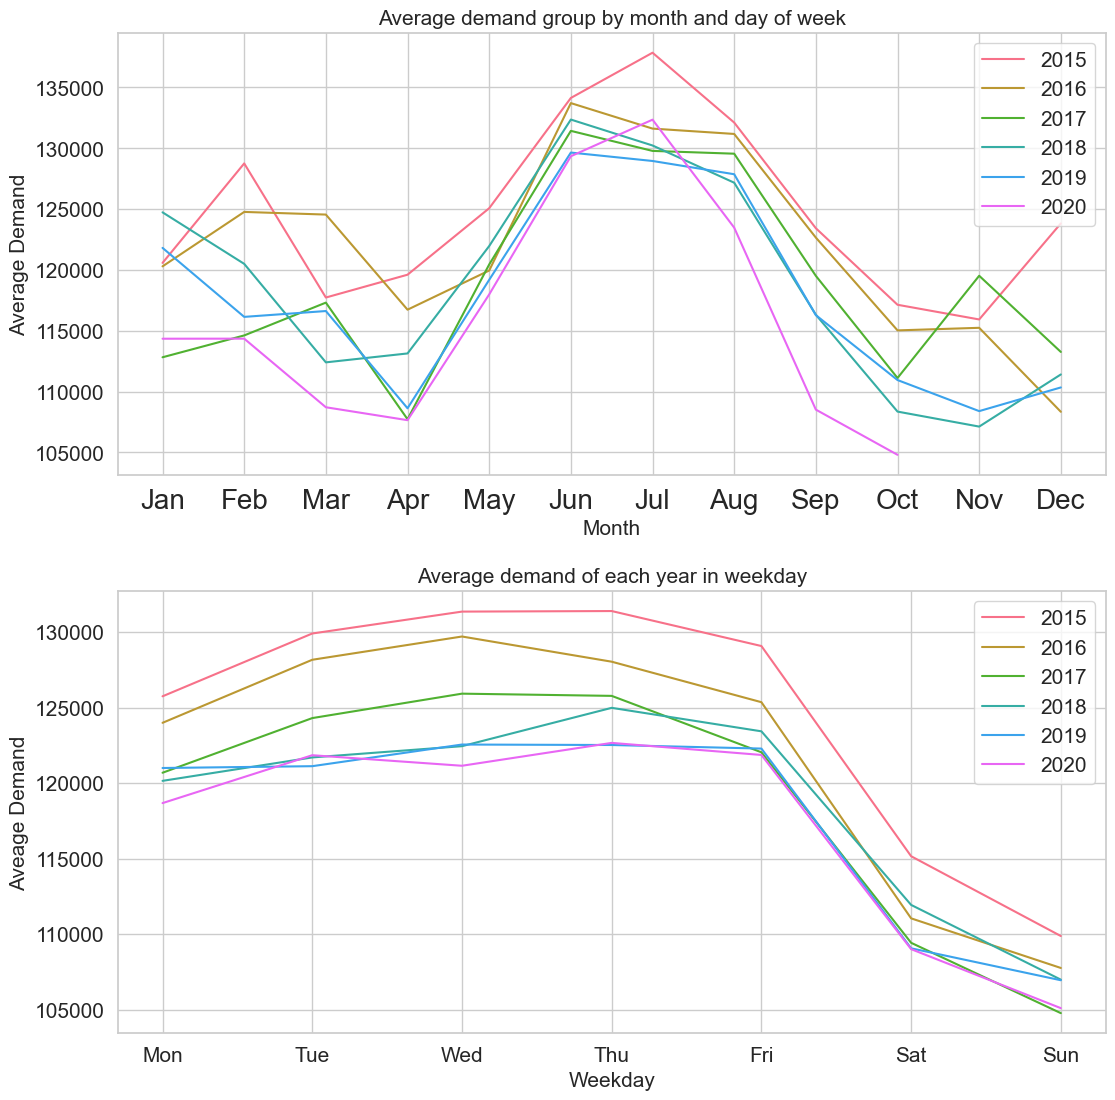

In [18]:
# Create day month year variable
demand_dataset = pd.read_csv(fileName)
df = demand_dataset.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year 
df['month'] = df['date'].dt.month 
df['day'] = df['date'].dt.day
df['dayOfWeek'] = df['date'].dt.dayofweek

fig, axs = plt.subplots(2, 1, figsize=(12,12))
fig.tight_layout(pad=5)
ave_demand_month = df.groupby(['month', 'year'])['demand'].mean().reset_index()
monthPlot = sns.lineplot(ave_demand_month, x="month", y="demand", hue='year', palette=sns.color_palette("husl", 6), errorbar=('ci',False), ax=axs[0])
monthPlot.set_title('Average demand group by month and day of week', fontsize=15)
monthPlot.set_xlabel('Month', fontsize = 15)
monthPlot.set_xticks(range(1, 13))
monthPlot.set_ylabel('Average Demand', fontsize = 15)
monthPlot.tick_params(labelsize = 15)
monthPlot.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 20)
monthPlot.tick_params(axis='y', labelsize = 15)
monthPlot.legend(loc = 'upper right', fontsize = 15)

ave_demand_day = df.groupby(['dayOfWeek', 'year'])['demand'].mean().reset_index()
print(ave_demand_day)
dayPlot = sns.lineplot(ave_demand_day, x="dayOfWeek", y="demand", hue='year', palette=sns.color_palette("husl", 6), errorbar=('ci',False), ax=axs[1])
dayPlot.set_title('Average demand of each year in weekday', fontsize = 15)
dayPlot.set_xticks(range(0,7))
dayPlot.tick_params(labelsize = 15)
dayPlot.set_xlabel('Weekday', fontsize = 15)
dayPlot.set_ylabel('Aveage Demand', fontsize = 15)
dayPlot.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize = 15)
dayPlot.tick_params(axis='y', labelsize = 15)
dayPlot.legend(loc = 'upper right', fontsize = 15)
plt.show()

# 2.Data Pre-processing

### Fill missing value 

In [19]:
df.at[161, 'rainfall'] = 0
df.at[1377, 'rainfall'] = 0.4
df.at[1378, 'rainfall'] = 3.4
df['solar_exposure'].fillna(method = 'ffill', inplace = True)

### Convert categorical variable data type

In [20]:
df['school_day'] = df['school_day'].replace({'Y':1, 'N':0})
df['holiday'] = df['holiday'].replace({'Y':1, 'N':0})

### Convert max_temperature for normal distribution

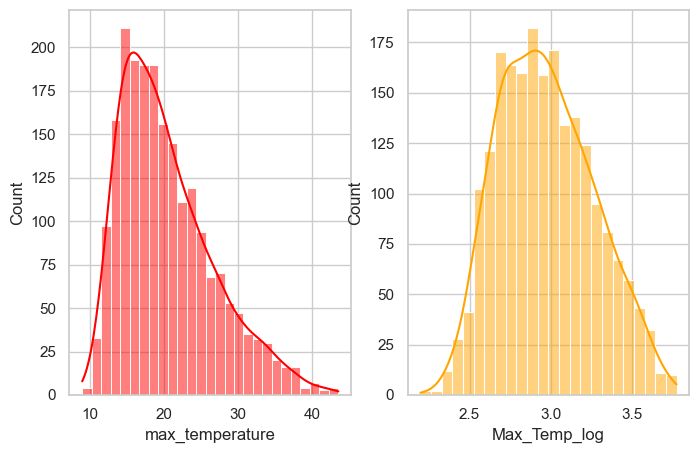

In [21]:
df['Max_Temp_log'] = np.log(df['max_temperature'].values)
fig, axs = plt.subplots(1, 2, figsize=(8,5), )
sns.histplot(x = df['max_temperature'], ax=axs[0], kde=True, color='red')
sns.histplot(x = df['Max_Temp_log'], ax=axs[1], kde=True, color='orange')
plt.show()

### Scale the dataset with feature selected and created

In [22]:
scaled_df=MinMaxScaler().fit_transform(df[['demand',
                                            'RRP',
                                            'min_temperature',
                                            'solar_exposure',
                                            'rainfall',
                                            'Max_Temp_log']])
scaled_df=pd.DataFrame(scaled_df, columns=['demand',
                                           'RRP',
                                            'min_temperature',
                                            'solar_exposure',
                                            'rainfall',
                                            'Max_Temp_log'])
scaled_df['holiday'] = df['holiday']
scaled_df['school_day'] = df['school_day']
scaled_df['month'] = df['month']
scaled_df['day'] = df['day']
scaled_df['year'] = df['year']
scaled_df['dayOfWeek'] = df['dayOfWeek']

print(scaled_df.head(n=4))

     demand       RRP  min_temperature  solar_exposure  rainfall  \
0  0.169948  0.006960         0.463504        0.702454  0.000000   
1  0.520242  0.008608         0.540146        0.800613  0.000000   
2  0.668613  0.008921         0.708029        0.791411  0.000000   
3  0.224830  0.006823         0.572993        0.751534  0.076923   

   Max_Temp_log  holiday  school_day  month  day  year  dayOfWeek  
0      0.694939        1           0      1    1  2015          3  
1      0.927427        0           0      1    2  2015          4  
2      0.917536        0           0      1    3  2015          5  
3      0.549760        0           0      1    4  2015          6  


Heat map after feature selection and log_tranformation of max_temperature

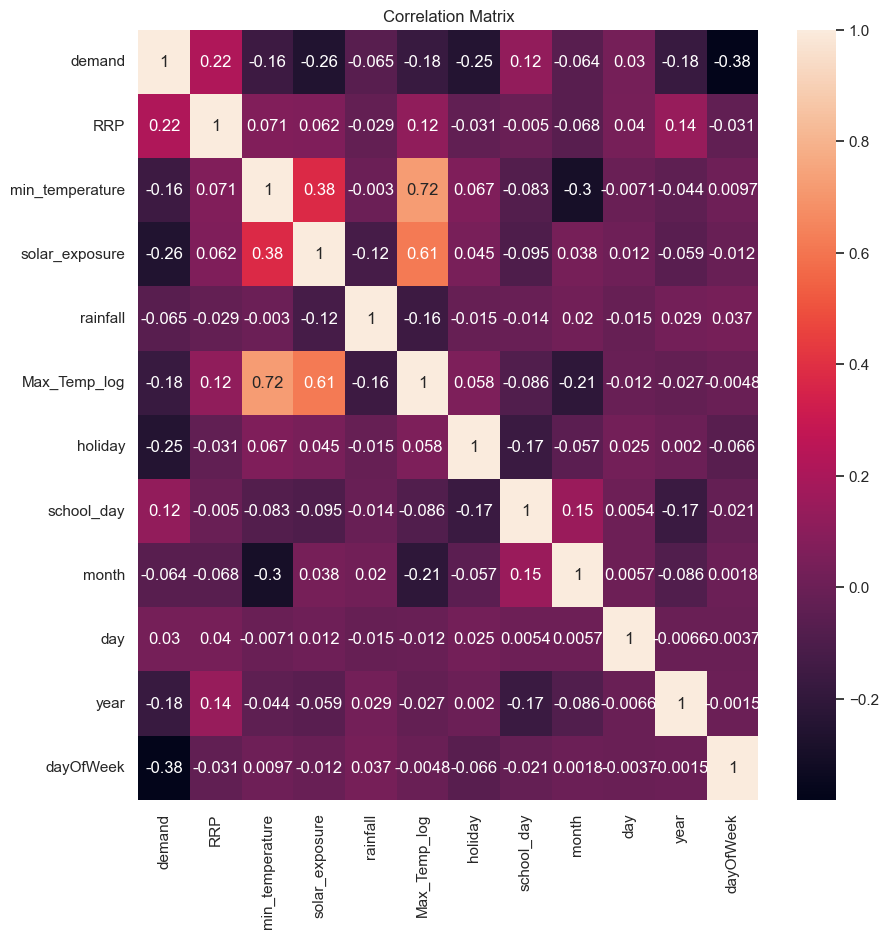

In [23]:
heat_map, ax = plt.subplots(figsize=(10, 10)) #Set size of the heat map
sns.heatmap(scaled_df[scaled_df.columns].corr(), annot=True, ax = ax)
plt.title("Correlation Matrix")
plt.show()

# 3.Model building

## Random Forest

### Train test split of 70:30

In [24]:
scaled_df.index = demand_dataset['date']
print(scaled_df)
pd.to_datetime(scaled_df.index)

train = scaled_df.loc[scaled_df.index < '2019-01-01']
test = scaled_df.loc[scaled_df.index >= '2019-01-01']

              demand       RRP  min_temperature  solar_exposure  rainfall  \
date                                                                        
2015-01-01  0.169948  0.006960         0.463504        0.702454  0.000000   
2015-01-02  0.520242  0.008608         0.540146        0.800613  0.000000   
2015-01-03  0.668613  0.008921         0.708029        0.791411  0.000000   
2015-01-04  0.224830  0.006823         0.572993        0.751534  0.076923   
2015-01-05  0.386139  0.007200         0.525547        0.920245  0.000000   
...              ...       ...              ...             ...       ...   
2020-10-02  0.169373  0.000000         0.445255        0.653374  0.000000   
2020-10-03  0.083949  0.000898         0.613139        0.585890  0.000000   
2020-10-04  0.105040  0.006823         0.470803        0.236196  0.000000   
2020-10-05  0.333285  0.009404         0.310219        0.202454  0.234432   
2020-10-06  0.438446  0.017966         0.302920        0.156442  0.018315   

### split feature and target variables

In [25]:
x_train = train.drop(labels='demand', axis=1)
y_train = train['demand']
x_test = test.drop(labels='demand', axis=1)
y_test = test['demand']

### Hyperparameter Tuning - Random Forest

In [26]:
rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {
    "n_estimators": np.arange(100, 1500, 100),
    "max_depth": np.arange(6, 20, 1),
    "max_leaf_nodes": np.arange(12, 20, 1),
}

rdms = RandomizedSearchCV(rf_model,
                          param_grid,
                          scoring='neg_mean_squared_error',
                          verbose = 2,
                          cv=8,
                          random_state=42,
                          n_iter=20)
rdms.fit(x_train, y_train)

print(rdms.best_params_)



Fitting 8 folds for each of 20 candidates, totalling 160 fits
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.5s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END .max_depth=19, max_leaf_nodes=17, n_estimators=1000; total time=   0.6s
[CV] END ..max_depth=14, max_leaf_nodes=18, n_estimators=400; total time=   0.2s
[CV] END ..max_depth=14, max_leaf_nodes=18, n_estimators=400; total time=   0.2s
[CV] END ..max_depth=14, max_leaf_nodes=18, n_estimators=400; total time=   0.2s
[CV] END ..max_depth=14, max_leaf_nodes=18, n_e

### Random Forest Forecasting

C:\Users\AB\AppData\Local\Temp\ipykernel_7936\3928158131.py:15: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(axis='x', nbins=5)


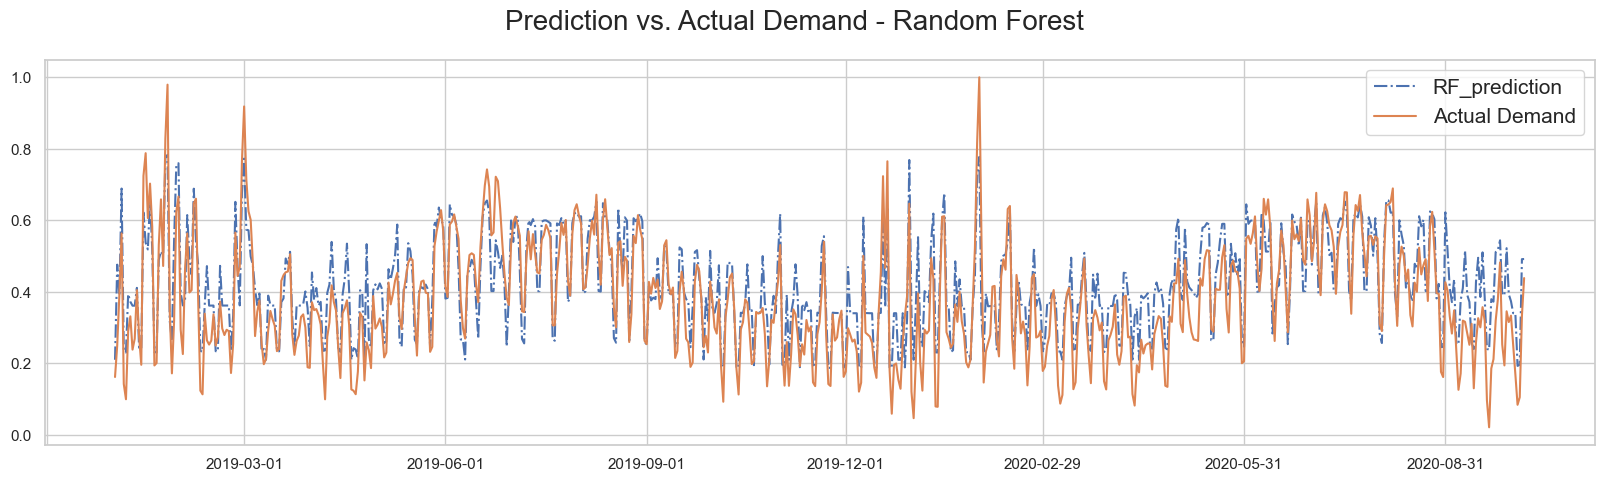

Execution time: 0.08945989608764648 seconds
Mean_squared_error: 0.007252426899782201
Mean_absolute_error: 0.06883755371910225
Root mean squared error: 0.08516118188342739


In [27]:
rf_tuned = rdms.best_estimator_

# Save the model
rf_model_name = 'Random_Forest.sav'
joblib.dump(rf_tuned, rf_model_name)

rf_start_time = time.time()
rf_tuned_pred = rf_tuned.predict(x_test)
rf_end_time = time.time()
rf_tuned_pred = pd.Series(rf_tuned_pred, index=y_test.index)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(rf_tuned_pred ,label = "RF_prediction", linestyle = 'dashdot')
plt.suptitle("Prediction vs. Actual Demand - Random Forest", fontsize= 20)
plt.plot(y_test, label = 'Actual Demand')
plt.locator_params(axis='x', nbins=5)
plt.legend(loc = 'upper right', fontsize=15)
rfPlot= plt.gca()
rfPlot.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()

print("Execution time:", rf_end_time - rf_start_time, "seconds")
print('Mean_squared_error:', mean_squared_error(y_test, rf_tuned_pred))
print('Mean_absolute_error:', mean_absolute_error(y_test, rf_tuned_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, rf_tuned_pred)))

## XGBoost

### Hyperparameter Tuning - XGBoost

In [28]:
xgb = XGBRegressor(n_jobs = -1, objective = 'reg:squarederror')
xgb_params = {
        'learning_rate' : [0.001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'min_child_weight': np.arange(1, 10, 1),
        "max_depth": np.arange(3, 10, 1),
        'gamma': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': np.arange(0.5, 1, 0.1),
        'colsample_bytree': [0.6, 0.8, 1.0],
}

xgb_randomSearch = RandomizedSearchCV(xgb, xgb_params, scoring='neg_mean_squared_error', verbose=1, cv=10, random_state=2, n_iter=50)
xgb_randomSearch.fit(x_train, y_train)

print(xgb_randomSearch.best_score_)
print(xgb_randomSearch.best_params_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
-0.0047626990806459045
{'subsample': 0.5, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 1.0}


### XGBoost Forecasting

C:\Users\AB\AppData\Local\Temp\ipykernel_7936\1195093817.py:15: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(axis='x', nbins=5)


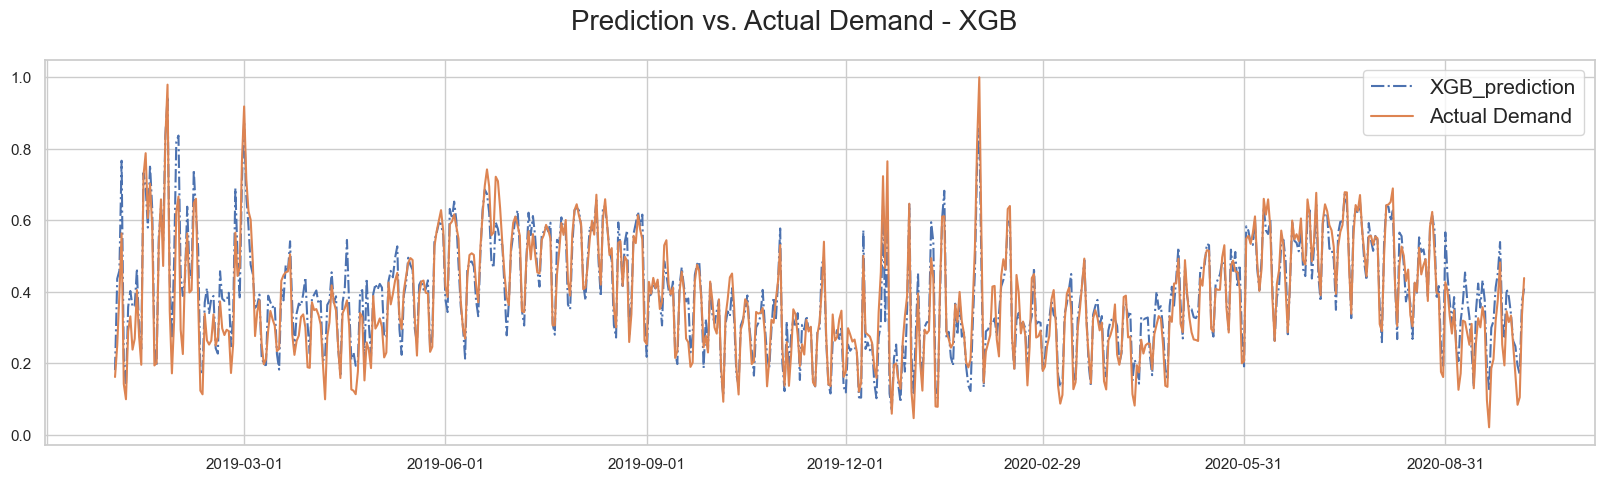

Execution time: 0.0019321441650390625 seconds
Mean_squared_error: 0.003172404203592458
Mean_absolute_error: 0.043073104028770924
Root mean squared error: 0.05632409966961264
R^2 Score is: 0.8765923465315809


In [29]:
xgb_tuned = xgb_randomSearch.best_estimator_

# Save the model
xgb_model_name = 'XGBoost.sav'
joblib.dump(xgb_tuned, xgb_model_name)

xgb_start_time = time.time()
xgb_tuned_pred = xgb_tuned.predict(x_test)
xgb_end_time = time.time()
xgb_tuned_pred = pd.Series(xgb_tuned_pred, index=y_test.index)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(xgb_tuned_pred ,label = "XGB_prediction", linestyle = 'dashdot')
plt.suptitle("Prediction vs. Actual Demand - XGB", fontsize= 20)
plt.plot(y_test, label = 'Actual Demand')#, linestyle = 'dashdot')
plt.locator_params(axis='x', nbins=5)
plt.legend(loc = 'upper right', fontsize=15)
xgbPlot= plt.gca()
import matplotlib.dates as mdates
xgbPlot.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()
print("Execution time:", xgb_end_time - xgb_start_time, "seconds")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Mean_squared_error:', mean_squared_error(y_test, xgb_tuned_pred))
print('Mean_absolute_error:', mean_absolute_error(y_test, xgb_tuned_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, xgb_tuned_pred)))
print('R^2 Score is:', r2_score(y_test, xgb_tuned_pred))

## Long Short Term Memory

### Only take weekday of the date categorical variable

In [30]:
scaled_df=MinMaxScaler().fit_transform(df[['demand',
                                            'RRP',
                                            'min_temperature',
                                            'solar_exposure',
                                            'rainfall',
                                            'Max_Temp_log']])
scaled_df=pd.DataFrame(scaled_df, columns=['demand',
                                           'RRP',
                                            'min_temperature',
                                            'solar_exposure',
                                            'rainfall',
                                            'Max_Temp_log'])
scaled_df['holiday'] = df['holiday']
scaled_df['school_day'] = df['school_day']
scaled_df['dayOfWeek'] = df['dayOfWeek']

print(scaled_df.head(n=4))

     demand       RRP  min_temperature  solar_exposure  rainfall  \
0  0.169948  0.006960         0.463504        0.702454  0.000000   
1  0.520242  0.008608         0.540146        0.800613  0.000000   
2  0.668613  0.008921         0.708029        0.791411  0.000000   
3  0.224830  0.006823         0.572993        0.751534  0.076923   

   Max_Temp_log  holiday  school_day  dayOfWeek  
0      0.694939        1           0          3  
1      0.927427        0           0          4  
2      0.917536        0           0          5  
3      0.549760        0           0          6  


### Reshape dataset for LSTM

In [31]:
def convert_to_X_y(dataframe, window, forecasting_time):
    dataframe = dataframe.to_numpy()
    X = []
    y = []
    for i in range (window, len(dataframe) - forecasting_time + 1):
        X.append(dataframe[i - window:i, 0: dataframe.shape[1]])
        y.append(dataframe[i+forecasting_time - 1: i+ forecasting_time, 0])
    return np.array(X), np.array(y)

window_size = 7
forecasting_time = 1
X, y = convert_to_X_y(scaled_df, window_size, forecasting_time)


X_train, y_train = X[:1461], y[:1461]
X_test, y_test = X[1461:2099], y[1461:2099]

### Model building
(Hyper parameter tuning is already conducted in model_building.ipynb)

Set random seed

In [32]:
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

Configure the algorithm

In [33]:
lstm_model = Sequential()
lstm_model.add(LSTM(192, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences= True))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(y.shape[1], activation = 'linear'))

lstm_model.summary()
cp = ModelCheckpoint('lstm_model_from_tuning/', save_best_only=True)
lstm_model.compile(loss = 'mse',
                    optimizer=Adam(learning_rate=0.01),
                    metrics = [RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 192)            155136    
                                                                 
 lstm_1 (LSTM)               (None, 32)                28800     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 183969 (718.63 KB)
Trainable params: 183969 (718.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Training

In [34]:
lstm_model.fit(X_train, y_train, epochs=50, batch_size= 10, validation_data=(X_test, y_test), verbose= 1, callbacks = [cp])
best_LSTM = load_model('lstm_model_from_tuning/')

Epoch 1/50
142/147 [===========================>..] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.2001INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 3s 13ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 2/50
144/147 [============================>.] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1228INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 3/50
145/147 [============================>.] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1171INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 4/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 5/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 6/50
140/147 [===========================>..] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1010INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 7/50
137/147 [==========================>...] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0993INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964
Epoch 8/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 9/50
138/147 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0945INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0089 - root_mean_squared_error: 0.0946 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 10/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 11/50
141/147 [===========================>..] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0934INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919
Epoch 12/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 13/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 14/50
137/147 [==========================>...] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0922INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900
Epoch 15/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 16/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 17/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 18/50
135/147 [==========================>...] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0876INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 19/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 20/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 21/50
134/147 [==========================>...] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0876INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 22/50
133/147 [==========================>...] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0843INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 23/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 24/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 25/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 26/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 27/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0089 - val_root_

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 13ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 30/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 31/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 32/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 33/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 34/50
142/147 [===========================>..] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0800INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0840
Epoch 35/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 36/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 37/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 38/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 39/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0076 - val_root_

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 45/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 46/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 47/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 48/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 49/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0078 - val_root_

### LSTM Forecast

20/20 [==============================] - 0s 2ms/step


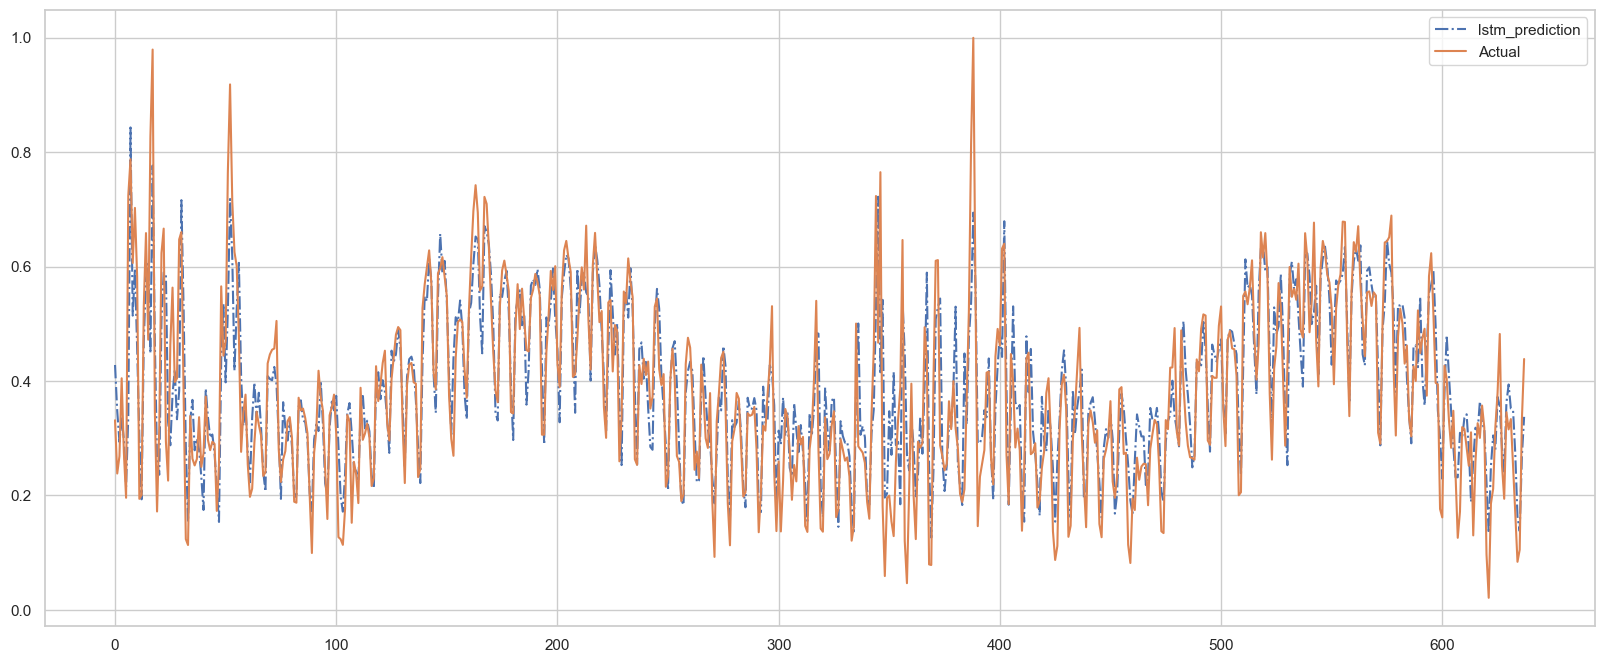

Execution time: 0.21683859825134277 seconds
Mean_squared_error: 0.006711800736504271
Mean_absolute_error: 0.05915758494359119
Root mean squared error: 0.08192558047706633
R^2 Score is: 0.7379043057988026


In [35]:
lstm_start_time = time.time()
test_prediction = best_LSTM.predict(X_test)
lstm_end_time = time.time()
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_prediction, linestyle = 'dashdot', label ='lstm_prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

print("Execution time:", lstm_end_time - lstm_start_time, "seconds")
print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))
print('R^2 Score is:', r2_score(y_test, test_prediction))